In [1]:
import csv
import numpy as np

In [2]:
with open('input.csv', 'r') as csvfile:
    inputs = list(csv.reader(csvfile))
    inputs = [
        [float(num) for num in row]
        for row in inputs
        if '-999' not in row
    ]
inputs = np.array(inputs)

with open('output.csv', 'r') as csvfile:
    outputs = list(csv.reader(csvfile)) #[1:] # Skip the first row
    outputs = [
        [float(num) for num in row]
        for row in outputs
    ]
outputs = np.array(outputs)

Get the depths with output values

In [3]:
# Output depths
out_depths = outputs[:,0]
out_depths = [round(depth, 1) for depth in out_depths]

# Input depths
in_depths = inputs[:,0]
in_depths = [round(depth, 1) for depth in in_depths]

In [4]:
X = []
Y = []

# inputs = inputs[:,1:] #remove the first redundant column
# Map output values to inputs
for out_idx, depth in enumerate(out_depths):
    if depth in in_depths:
        # Map the inputs to outputs by depth
        X.append(inputs[in_depths.index(depth)])
        Y.append(outputs[out_idx][1])
X = np.array(X)
Y = np.array(Y)

Scale inputs so that mean = 0 / variance = 1

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

input_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
input_scaler.fit(inputs)
output_scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
output_scaler.fit(outputs[:,-1].reshape(-1, 1))

X = input_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1994)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# Y_scaled = output_scaler.transform(Y.reshape(-1, 1))

(189, 5)
(189,)
(48, 5)
(48,)


Naive model in scikit-learn for testing model parameters

In [6]:
# from sklearn.neural_network import MLPRegressor

# models = []
# for hidden_size in range(10, 210, 10):
#     for lr in [0.1, 0.01, 0.001]:
#         for alpha in [0.05, 0.1, 0.25, 0.5]:
#             model = MLPRegressor(hidden_layer_sizes=(hidden_size,), 
#                                  activation='relu', 
#                                  solver='lbfgs',
#                                  alpha=alpha,
#                                  max_iter=500,
#                                  learning_rate_init=lr,
#                                  validation_fraction=0.1,
#                                  random_state=1994,
#                                  verbose=False)
#             model.fit(X, Y)
#             score = model.score(X,Y)
#             print('Testing with hidden_size=%s, lr=%s, alpha:%s, score:%s' % (hidden_size, lr, alpha, score))
#             models.append({'model': model, 'score': score})

In [7]:
# Best score
# models = sorted(models, key=lambda x:-x['score'])
# top_model = models[0]['model']
# print(top_model)

# From this we found out that best model has alpha=0.05; hidden_size=170; lr=0.1
# MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
#        beta_2=0.999, early_stopping=False, epsilon=1e-08,
#        hidden_layer_sizes=(170,), learning_rate='constant',
#        learning_rate_init=0.1, max_iter=500, momentum=0.9,
#        nesterovs_momentum=True, power_t=0.5, random_state=1994,
#        shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
#        verbose=False, warm_start=False)

In [8]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(170,), 
                     activation='relu', 
                     solver='lbfgs',
                     alpha=0.05,
                     max_iter=500,
                     learning_rate_init=0.1,
                     validation_fraction=0.,
                     random_state=1994,
                     verbose=False)
model.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(170,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1994,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.0,
       verbose=False, warm_start=False)

In [9]:
# print(Y)

In [10]:
# print(model.predict(X))

Calculate R^2 score of the model

In [11]:
model.score(X_test, y_test)

-2.386993342313885

More flexible model with ELU instead of ReLU

In [12]:
import torch
Y_view = np.reshape(y_train, (-1, 1)) # Transform Y into 2d array

from torch.autograd import Variable
X_var = Variable(torch.from_numpy(X_train).float())
Y_var = Variable(torch.from_numpy(Y_view).float())

In [13]:
import torch.nn as nn

class Simple_NN(nn.Module):
    
    def __init__(self, config):
        super(Simple_NN, self).__init__()
        
        self.hidden_size = config['hidden_size']
        self.dropout_keep_prob = config['dropout_keep_prob']
        
        self.linear = nn.Sequential(
            nn.Linear(5, self.hidden_size),
            nn.ReLU(),
            nn.Dropout(1 - self.dropout_keep_prob),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Dropout(1 - self.dropout_keep_prob),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Dropout(1 - self.dropout_keep_prob),
            nn.Linear(self.hidden_size, 1),
#             nn.Softplus()
        )
        
    def forward(self, inputs):
        output = self.linear(inputs)
        return output

In [14]:
import torch.optim as optim
from sklearn.metrics import r2_score

models = []
for hidden_size in range(10, 200, 10):
#     for lr in [0.1, 0.01, 0.001]:
    for dropout in [0.9, 0.8, 0.7, 0.6, 0.5]:
        # Training:
        all_losses = []

        model = Simple_NN({'hidden_size': hidden_size, 'dropout_keep_prob': dropout})
        # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        optimizer = optim.Adam(model.parameters())
        criterion = nn.SmoothL1Loss()

        for epoch in range(3000):
            optimizer.zero_grad()

            output = model(X_var)
            loss = criterion(output, Y_var)
            loss.backward()

            nn.utils.clip_grad_norm(model.parameters(), 5.)
            all_losses.append(loss.data[0])

        #     print('Epoch %s, loss: %s' % (epoch + 1, loss.data[0]))

            optimizer.step()

#             with torch.no_grad():
        model.eval()
        output_pred = model(Variable(torch.from_numpy(X_test).float()))
        output_pred = output_pred.data.numpy()

        # Calculate R2 of the pytorch model
        score = r2_score(y_test, output_pred)

        print('Hidden size: %s, Score: %s' % (hidden_size, score))

        models.append({
            'model': model, 
            'score': score, 
            'losses': all_losses, 
            'hidden_size': hidden_size, 
#             'lr': lr, 
            'dropout_keep': dropout
        })

/Users/2359media/anaconda/envs/yolo-keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/Users/2359media/anaconda/envs/yolo-keras/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Hidden size: 10, Score: 0.17294264802870574
Hidden size: 10, Score: 0.10035018680252206
Hidden size: 10, Score: 0.06574414881345014
Hidden size: 10, Score: -0.0021310752597687443
Hidden size: 10, Score: -0.027121258056786113
Hidden size: 20, Score: 0.1577281603519849
Hidden size: 20, Score: 0.14943001294260294
Hidden size: 20, Score: 0.06340301094712464
Hidden size: 20, Score: 0.10523018609041901
Hidden size: 20, Score: 0.062289866048051756
Hidden size: 30, Score: 0.10327227837810271
Hidden size: 30, Score: 0.10529010911022219
Hidden size: 30, Score: 0.08706013487515363
Hidden size: 30, Score: 0.08647624557177769
Hidden size: 30, Score: 0.09053757041268273
Hidden size: 40, Score: 0.08561937279902221
Hidden size: 40, Score: -0.12570535767114221
Hidden size: 40, Score: -0.01778464267459201
Hidden size: 40, Score: 0.037518652784926276
Hidden size: 40, Score: 0.09936505717353905
Hidden size: 50, Score: -0.15922222379766393
Hidden size: 50, Score: -0.1887969801620928
Hidden size: 50, Score:

In [15]:
# Best score
models = sorted(models, key=lambda x:-x['score'])
top_model = models[0]['model']
print(top_model)
print(models[0]['score'])
# print(models[0]['lr'])

Simple_NN(
  (linear): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.09999999999999998)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.09999999999999998)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.09999999999999998)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)
0.17294264802870574


KeyError: 'lr'

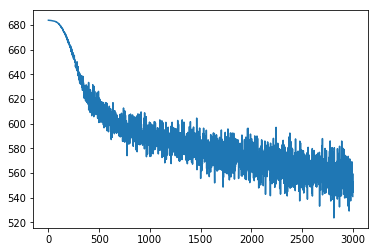

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(models[0]['losses'])
plt.show()

In [ ]:
top_model.eval()
output_pred = top_model(Variable(torch.from_numpy(X_test).float()))

In [ ]:
# Convert back to numpy
output_pred = output_pred.data.numpy()
print(output_pred)

In [ ]:
print(y_test)

In [ ]:
from sklearn.metrics import r2_score
# Calculate R2 of the pytorch model
score = r2_score(y_test, output_pred)
print(score)